In [1]:
import torch
from PIL import Image
import os
import random
from lavis.models import load_model_and_preprocess
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载 BLIP 和 ALBEF 模型及预处理器
blip_model, blip_vis_processors, blip_txt_processors = load_model_and_preprocess(
    name="blip_feature_extractor", 
    model_type="base", 
    is_eval=True, 
    device=device
)

albef_model, albef_vis_processors, albef_txt_processors = load_model_and_preprocess(
    name="albef_feature_extractor", 
    model_type="base", 
    is_eval=True, 
    device=device
)

blip2_model, blip2_vis_processors, blip2_txt_processors = load_model_and_preprocess(
    name="blip2_feature_extractor", 
    model_type="pretrain", 
    is_eval=True, 
    device=device
)

/home/sunj11/anaconda3/envs/lavis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sunj11/anaconda3/envs/lavis/lib/python3.8/site-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/home/sunj11/anaconda3/envs/lavis/lib/python3.8/site-packages/fairscale/experimental/nn/offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore
/home/sunj11/anaconda3/envs/lavis/lib/python3.8/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_d

reshape position embedding from 256 to 196


/home/sunj11/anaconda3/envs/lavis/lib/python3.8/site-packages/lavis/models/eva_vit.py:433: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(cached_file,

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# BLIP model
blip_num_params = count_parameters(blip_model)
print(f"Number of parameters in BLIP model: {blip_num_params}")

# ALBEF model
albef_num_params = count_parameters(albef_model)
print(f"Number of parameters in ALBEF model: {albef_num_params}")

# BLIP2 model
blip2_num_params = count_parameters(blip2_model)
print(f"Number of parameters in BLIP2 model: {blip2_num_params}")

Number of parameters in BLIP model: 223450881
Number of parameters in ALBEF model: 209888571
Number of parameters in BLIP2 model: 186705470


In [3]:
import os
from pycocotools.coco import COCO
import random
import pandas as pd

# COCO 数据集路径
coco_dir = "/home/sunj11/Documents/VLM/BLIP/dataset/coco"
captions_file = os.path.join(coco_dir, "annotations", "captions_val2014.json")
instances_file = os.path.join(coco_dir, "annotations", "instances_val2014.json")

# 加载 captions 和 instances 数据
captions_coco = COCO(captions_file)
instances_coco = COCO(instances_file)

# 获取所有类别
all_categories = instances_coco.loadCats(instances_coco.getCatIds())

# 随机选择20个类别
selected_categories = random.sample(all_categories, 10)

# 初始化结果列表
results = []

# 对每个选定的类别
for category in selected_categories:
    # 获取该类别的所有图像ID
    img_ids = instances_coco.getImgIds(catIds=[category['id']])
    
    # 如果该类别的图像少于100，就全部使用，否则随机选择100个
    selected_img_ids = random.sample(img_ids, min(100, len(img_ids)))
    
    for img_id in selected_img_ids:
        # 获取caption
        ann_ids = captions_coco.getAnnIds(imgIds=img_id)
        captions = captions_coco.loadAnns(ann_ids)
        
        # 随机选择一个caption
        caption = random.choice(captions)['caption']
        
        # 添加到结果列表
        results.append({
            'image_id': img_id,
            'category': category['name'],
            'caption': caption
        })

# 将结果转换为DataFrame
df = pd.DataFrame(results)

# 打印结果统计
print(f"Total samples: {len(df)}")
print(f"Number of categories: {len(df['category'].unique())}")
print("\nSamples per category:")
print(df['category'].value_counts())

# 保存结果到CSV文件
output_file = os.path.join(coco_dir, "coco_20_categories_2000_samples.csv")
df.to_csv(output_file, index=False)
print(f"\nResults saved to {output_file}")

# 打印前几个样本
print("\nSample data:")
print(df.head())

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=4.37s)
creating index...
index created!
Total samples: 1000
Number of categories: 10

Samples per category:
category
bicycle          100
surfboard        100
tennis racket    100
wine glass       100
person           100
couch            100
handbag          100
elephant         100
tie              100
microwave        100
Name: count, dtype: int64

Results saved to /home/sunj11/Documents/VLM/BLIP/dataset/coco/coco_20_categories_2000_samples.csv

Sample data:
   image_id category                                            caption
0    312559  bicycle    A bus is making a left turn behind a white car.
1    277094  bicycle      many vehicles on a city street near buildings
2    315976  bicycle  A red double decker bus is riding down the roa...
3    221094  bicycle  A man riding a motorcycle with a woman on back...
4    287235  bicycle  A police officer is riding

In [4]:
import random
from pycocotools.coco import COCO
import pandas as pd
import os

# COCO 数据集路径
coco_dir = "/home/sunj11/Documents/VLM/BLIP/dataset/coco"
annotation_file = os.path.join(coco_dir, "annotations", "instances_val2014.json")
caption_file = os.path.join(coco_dir, "annotations", "captions_val2014.json")

# 加载 COCO 数据集
coco = COCO(annotation_file)
coco_caps = COCO(caption_file)

# 定义 9 个大类及其包含的类别
supercategories = {
    # "person": ["person"],
    "vehicle": ["bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat"],
    "outdoor": ["traffic light", "fire hydrant", "stop sign", "parking meter", "bench"],
    "animal": ["bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe"],
    "accessory": ["backpack", "umbrella", "handbag", "tie", "suitcase"],
    "sports": ["frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket"],
    "kitchen": ["bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl"],
    "food": ["banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake"],
    "furniture": ["chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
}

# # 从每个大类中随机选择一个类别
# selected_categories = [random.choice(categories) for categories in supercategories.values()]

# 随机选择5个大类
selected_supercategories = random.sample(list(supercategories.keys()), 8)

# 从每个选中的大类中随机选择一个类别
selected_categories = [random.choice(supercategories[supercat]) for supercat in selected_supercategories]

print("Selected supercategories:", selected_supercategories)
print("Selected categories:", selected_categories)

# 初始化结果列表
results = []

# 对每个选定的类别
for category in selected_categories:
    # 获取该类别的所有图像ID
    cat_ids = coco.getCatIds(catNms=[category])
    img_ids = coco.getImgIds(catIds=cat_ids)
    
    # 随机选择图像，直到每个类别有大约 2000 / 9 ≈ 222 个样本
    selected_img_ids = random.sample(img_ids, min(100, len(img_ids)))
    
    for img_id in selected_img_ids:
        # 获取图像信息
        img_info = coco.loadImgs(img_id)[0]
        
        # 获取 caption
        ann_ids = coco_caps.getAnnIds(imgIds=img_id)
        anns = coco_caps.loadAnns(ann_ids)
        captions = [ann['caption'] for ann in anns]
        
        if captions:
            # 随机选择一个 caption
            caption = random.choice(captions)
            
            # 添加到结果列表
            results.append({
                'image_id': img_id,
                'file_name': img_info['file_name'],
                'category': category,
                'caption': caption
            })

# 将结果转换为DataFrame
df = pd.DataFrame(results)

# 打印结果统计
print(f"Total samples: {len(df)}")
print(f"Number of categories: {len(df['category'].unique())}")
print("\nSamples per category:")
print(df['category'].value_counts())

# 保存结果到CSV文件
output_file = os.path.join(coco_dir, "coco_9_supercategories_2000_samples.csv")
df.to_csv(output_file, index=False)
print(f"\nResults saved to {output_file}")

# 打印前几个样本
print("\nSample data:")
print(df.head())

loading annotations into memory...
Done (t=5.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
Selected supercategories: ['sports', 'kitchen', 'food', 'furniture', 'accessory', 'outdoor', 'animal', 'vehicle']
Selected categories: ['skis', 'knife', 'broccoli', 'book', 'suitcase', 'parking meter', 'horse', 'boat']
Total samples: 800
Number of categories: 8

Samples per category:
category
skis             100
knife            100
broccoli         100
book             100
suitcase         100
parking meter    100
horse            100
boat             100
Name: count, dtype: int64

Results saved to /home/sunj11/Documents/VLM/BLIP/dataset/coco/coco_9_supercategories_2000_samples.csv

Sample data:
   image_id                      file_name category  \
0    426259  COCO_val2014_000000426259.jpg     skis   
1    267684  COCO_val2014_000000267684.jpg     skis   
2    574108  COCO_val2014_000000574108.jpg     skis   
3    3282

In [5]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据
coco_dir = "/home/sunj11/Documents/VLM/BLIP/dataset/coco"
df = pd.read_csv(os.path.join(coco_dir, "coco_10_specific_categories_2000_samples.csv"))

# 获取唯一的类别并创建映射
unique_categories = df['category'].unique()
category_to_id = {cat: i for i, cat in enumerate(unique_categories)}

# 准备标签和文本
labels = [category_to_id[cat] for cat in df['category']]
captions = df['caption'].tolist()

# 提取文本特征
def extract_features(model, txt_processor, texts, batch_size=64, is_albef=False):
    features = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        batch_texts = [txt_processor(caption) for caption in batch]
        with torch.no_grad():
            if is_albef:
                # 为 ALBEF 模型创建一个随机图像批次
                dummy_images = torch.randn(len(batch_texts), 3, 224, 224).to(device)
                batch_features = model.extract_features({
                    "text_input": batch_texts, 
                    "image": dummy_images
                }, mode="text").text_embeds_proj[:, 0].cpu().numpy()
            else:
                batch_features = model.extract_features({
                    "text_input": batch_texts
                }, mode="text").text_embeds_proj[:, 0].cpu().numpy()
        features.append(batch_features)
    return np.concatenate(features)


print("Extracting BLIP2 features...")
blip2_features = extract_features(blip2_model, blip2_txt_processors["eval"], captions)
print("Extracting BLIP features...")
blip_features = extract_features(blip_model, blip_txt_processors["eval"], captions)
print("Extracting ALBEF features...")
albef_features = extract_features(albef_model, albef_txt_processors["eval"], captions, is_albef=True)

# # Perform t-SNE
# print("Performing t-SNE...")
# tsne = TSNE(n_components=2, random_state=42)
# blip2_tsne = tsne.fit_transform(blip2_features)
# blip_tsne = tsne.fit_transform(blip_features)
# albef_tsne = tsne.fit_transform(albef_features)


Extracting BLIP2 features...


100%|██████████| 75/75 [00:02<00:00, 26.28it/s]


Extracting BLIP features...


100%|██████████| 75/75 [00:02<00:00, 28.26it/s]


Extracting ALBEF features...


100%|██████████| 75/75 [00:04<00:00, 15.44it/s]


(4791, 256)

(4791, 256)

Performing 2D t-SNE...


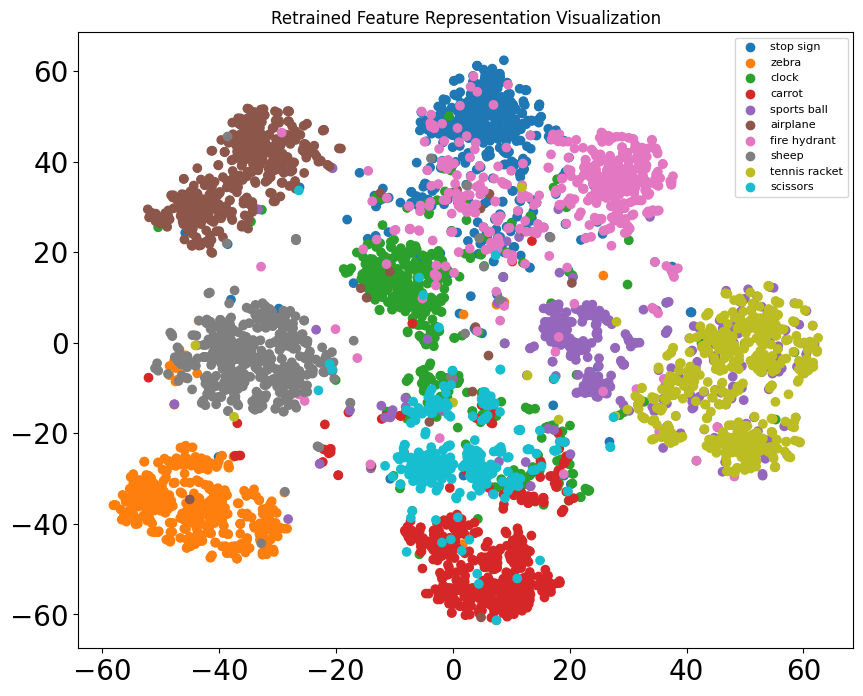

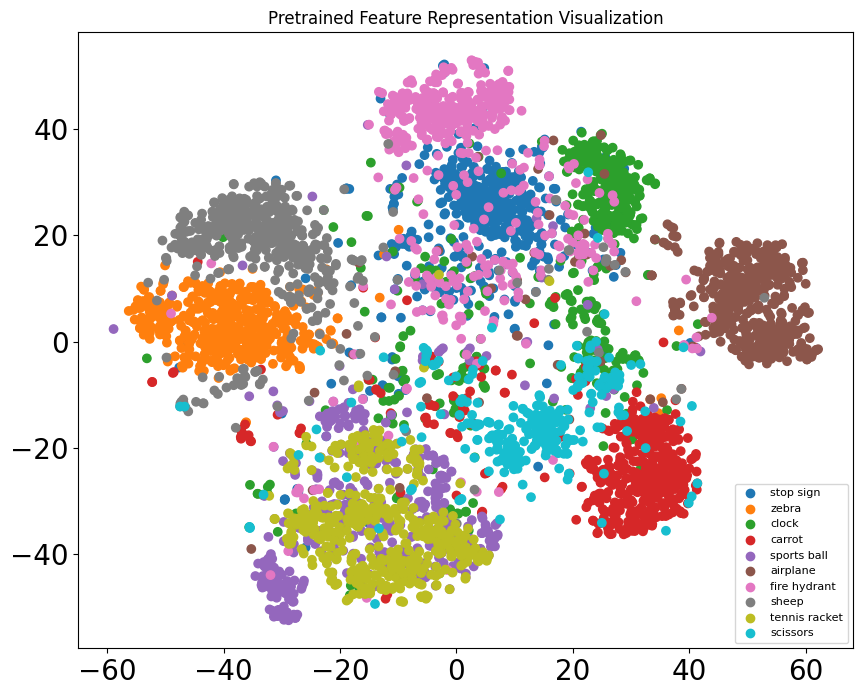

2D Visualization with category labels complete. Images saved.


In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import os

# 确保image文件夹存在
if not os.path.exists('image'):
    os.makedirs('image')

# 定义10个类别
selected_categories = ['stop sign', 'zebra', 'clock', 'carrot', 'sports ball', 
                      'airplane', 'fire hydrant', 'sheep', 'tennis racket', 'scissors']
# selected_categories = ["banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake"]
# Perform 2D t-SNE
print("Performing 2D t-SNE...")
tsne_2d = TSNE(
    n_components=2,
    perplexity=40,    # 对于4791个点，40是个比较合适的值
    n_iter=1000,      # 默认1000次迭代通常足够
    learning_rate='auto',  
    random_state=42,
    metric='euclidean'  # 使用欧氏距离
)
blip_tsne_2d = tsne_2d.fit_transform(blip_features)
albef_tsne_2d = tsne_2d.fit_transform(albef_features)

# 绘制BLIP图
plt.figure(figsize=(10, 8))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

scatter = plt.scatter(blip_tsne_2d[:, 0], blip_tsne_2d[:, 1], c=labels, cmap='tab10')
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10)], label=selected_categories[i]) 
                  for i in range(10)]
plt.legend(handles=legend_elements, loc='upper right', prop={'size': 8})
plt.title('Retrained Feature Representation Visualization')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(20))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.savefig('image/blip_tsne.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 绘制ALBEF图
plt.figure(figsize=(10, 8))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

scatter = plt.scatter(albef_tsne_2d[:, 0], albef_tsne_2d[:, 1], c=labels, cmap='tab10')
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10)], label=selected_categories[i]) 
                  for i in range(10)]
plt.legend(handles=legend_elements, loc='lower right', prop={'size': 8})
plt.title('Pretrained Feature Representation Visualization')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(20))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.savefig('image/albef_tsne.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("2D Visualization with category labels complete. Images saved.")

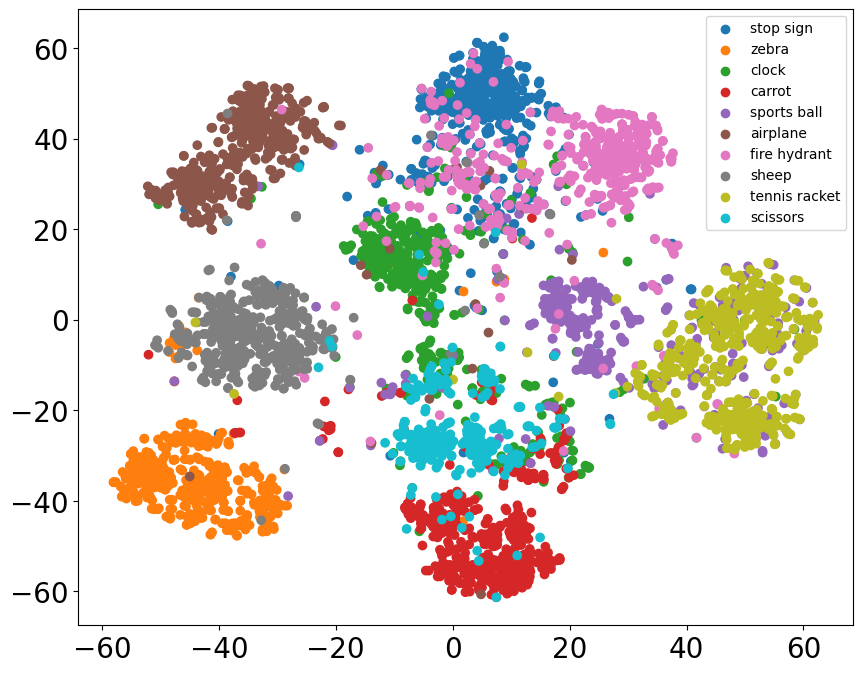

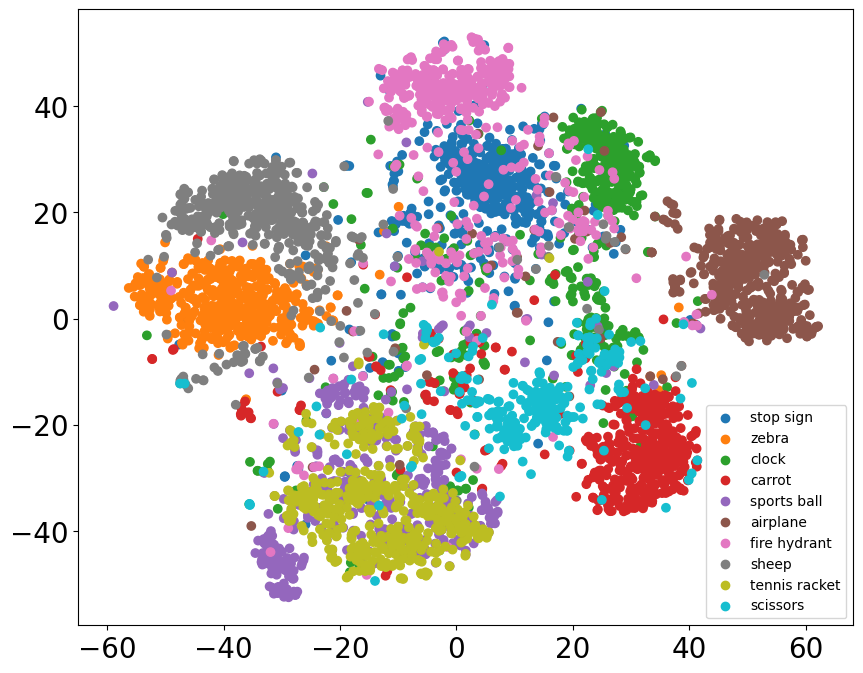

2D Visualization with category labels complete. Images saved.


In [7]:
# 绘制BLIP图
plt.figure(figsize=(10, 8))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

scatter = plt.scatter(blip_tsne_2d[:, 0], blip_tsne_2d[:, 1], c=labels, cmap='tab10')
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10)], label=selected_categories[i]) 
                  for i in range(10)]
plt.legend(handles=legend_elements, loc='upper right', prop={'size': 10})
# plt.title('Retrained Feature Representation Visualization')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(20))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.savefig('image/blip_tsne.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 绘制ALBEF图
plt.figure(figsize=(10, 8))
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

scatter = plt.scatter(albef_tsne_2d[:, 0], albef_tsne_2d[:, 1], c=labels, cmap='tab10')
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10)], label=selected_categories[i]) 
                  for i in range(10)]
plt.legend(handles=legend_elements, loc='lower right', prop={'size': 10})
# plt.title('Pretrained Feature Representation Visualization')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(20))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(20))
plt.savefig('image/albef_tsne.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("2D Visualization with category labels complete. Images saved.")

In [17]:
# BLIP图
plt.figure(figsize=(11, 8))

# 主散点图
plt.scatter(blip_tsne_2d[:, 0], blip_tsne_2d[:, 1], c=labels, cmap='tab10')
plt.xticks([])  # 去掉x轴刻度
plt.yticks([])  # 去掉y轴刻度

# 添加图例
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10)], label=selected_categories[i]) 
                  for i in range(10)]
plt.legend(handles=legend_elements, 
          loc='center left',      # 放在右侧中间
          bbox_to_anchor=(1, 0.5),# 调整位置
          prop={'size': 25},      # 增大字体
          labelspacing=1)       # 增加行间距

plt.tight_layout()  # 自动调整布局
plt.savefig('image/blip_tsne.png', dpi=300, bbox_inches='tight')
plt.close()

# ALBEF图保持不变
plt.figure(figsize=(10, 8))
scatter = plt.scatter(albef_tsne_2d[:, 0], albef_tsne_2d[:, 1], c=labels, cmap='tab10')
plt.xticks([])
plt.yticks([])
plt.savefig('image/albef_tsne.png', dpi=300, bbox_inches='tight')
plt.close()

print("2D Visualization complete. Images saved.")

2D Visualization complete. Images saved.


In [18]:
import matplotlib.pyplot as plt

# BLIP图
plt.figure(figsize=(11, 8))

# 主散点图
plt.scatter(blip_tsne_2d[:, 0], blip_tsne_2d[:, 1], c=labels, cmap='tab10')
plt.xticks([])  # 去掉x轴刻度
plt.yticks([])  # 去掉y轴刻度

# 添加图例，增加 marker size
legend_elements = [plt.scatter([], [], c=[plt.cm.tab10(i/10)], s=200, label=selected_categories[i]) 
                  for i in range(10)]
plt.legend(handles=legend_elements, 
          loc='center left',      # 放在右侧中间
          bbox_to_anchor=(1, 0.5),# 调整位置
          prop={'size': 25},      # 增大字体
          labelspacing=1)       # 增加行间距

plt.tight_layout()  # 自动调整布局
plt.savefig('image/blip_tsne.png', dpi=300, bbox_inches='tight')
plt.close()

# ALBEF图保持不变
plt.figure(figsize=(10, 8))
scatter = plt.scatter(albef_tsne_2d[:, 0], albef_tsne_2d[:, 1], c=labels, cmap='tab10')
plt.xticks([])
plt.yticks([])
plt.savefig('image/albef_tsne.png', dpi=300, bbox_inches='tight')
plt.close()

print("2D Visualization complete. Images saved.")

2D Visualization complete. Images saved.
